# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

## Step 0: Load The Data

In [1]:
import pickle

training_file = '../data/train.p'
validation_file= '../data/test.p'
testing_file = '../data/valid.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
import numpy as np

n_train = len(X_train)
n_validation = len(X_valid)
n_test = len(X_test)
image_shape = np.shape(X_train[0])
n_classes = len(np.unique(y_train)) 

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 12630
Number of testing examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

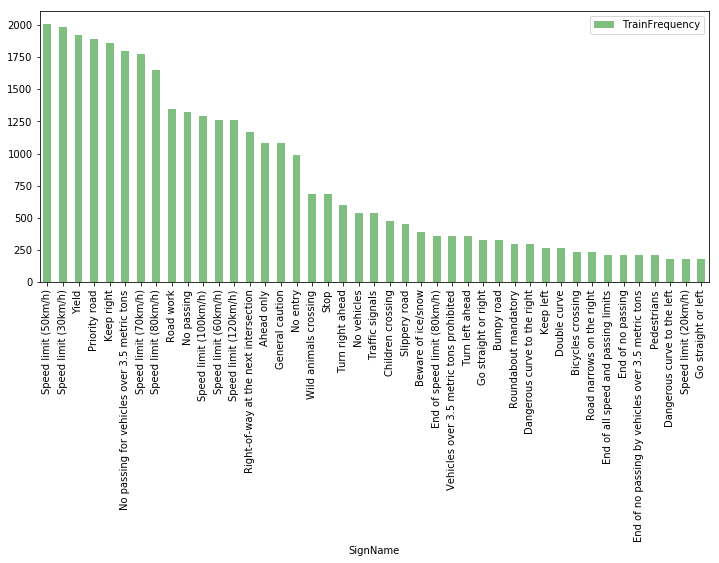

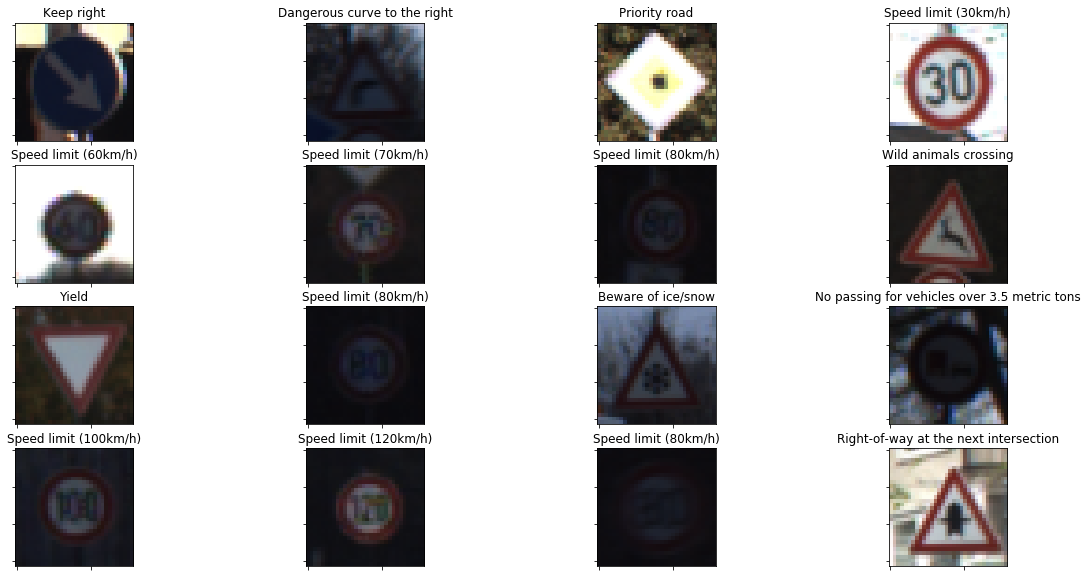

In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import pandas as pd
import random

%matplotlib inline

signal_names = pd.read_csv("signnames.csv")
label_descriptions = signal_names["SignName"]

traindata = pd.DataFrame(y_train, columns=["ClassId"])
traindata = traindata.merge(signal_names, how="left", left_on="ClassId", right_on="ClassId")
traindata = traindata.rename(columns={'ClassId': 'TrainFrequency'})

datacount = traindata.groupby(["SignName"]).count()
datacount = datacount.sort_values(by="TrainFrequency", ascending=False)
datacount.plot.bar(figsize=(12, 5), color=['g'], width=.5, alpha=0.5)

fig, axarr = plt.subplots(4,4,figsize=(20, 10))
for j in range(4):
    for i in range(4):
        index = random.randint(0, n_train)
        sample_images = X_train[index]
        axarr[i,j].set_yticklabels([])
        axarr[i,j].set_xticklabels([])
        axarr[i,j].imshow(sample_images)
        axarr[i,j].title.set_text(label_descriptions[y_train[index]])

plt.show()   

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [25]:
def preprocess_imgs(rbg_imgs, axis=3):
    #convert to grayscale
    grayscaled_images = np.sum(rbg_imgs/3, axis=axis, keepdims=True)
    #normalize pixels
    return (grayscaled_images - 128.) / 128.

X_train_normed = preprocess_imgs(X_train)
X_valid_normed = preprocess_imgs(X_valid)
X_test_normed  = preprocess_imgs(X_test)

np.shape(X_train_normed[0])

(32, 32, 1)

### Model Architecture

In [6]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle

#p.s.: export JOBLIB_MULTIPROCESSING=1 solves warning

# Hyperparameters
epochs = 50
batch_size = 256
dropout = 0.5
learning_rate = 0.001

In [33]:
mu = 0
sigma = 0.1

weights = {
    'wc1': tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma)),
    'wc2': tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma)),
    'fc1' : tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma)),
    'fc2' : tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma)),
    'fc3' : tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
}

biases = {
    'bc1': tf.Variable(tf.zeros(6)),
    'bc2': tf.Variable(tf.zeros(16)),
    'fc1' : tf.Variable(tf.zeros(120)),
    'fc2' : tf.Variable(tf.zeros(84)),
    'fc3' : tf.Variable(tf.zeros(43))
}

def LeNet(x):
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1   = tf.nn.conv2d(x, weights['wc1'], strides=[1, 1, 1, 1], padding='VALID') + biases['bc1']
    conv1 = tf.nn.relu(conv1)
    
    # Pooling Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(
        conv1, 
        ksize=[1, 2, 2, 1], 
        strides=[1, 2, 2, 1], 
        padding='VALID')

    #  Layer 2: Convolutional. Output = 10x10x16.
    conv2   = tf.nn.conv2d(conv1, weights['wc2'], strides=[1, 1, 1, 1], padding='VALID') + biases['bc2']
    conv2 = tf.nn.relu(conv2)
    
    # Pooling Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(
        conv2, 
        ksize=[1, 2, 2, 1], 
        strides=[1, 2, 2, 1], 
        padding='VALID')

    # Flatten Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: FCL1 Input = 400. Output = 120.
    fc1 = tf.matmul(fc0, weights['fc1']) + biases['fc1']    
    fc1 = tf.nn.relu(fc1)    
    fc1 = tf.nn.dropout(fc1, keep_prob) 
    
    # Layer 4: FCL2 Input = 120. Output = 84.
    fc2 = tf.matmul(fc1, weights['fc2']) + biases['fc2']    
    fc2 = tf.nn.relu(fc2)        
    fc2 = tf.nn.dropout(fc2, keep_prob) 
    
    #  Layer 5: FCL3 Input = 84. Output = 43.
    logits = tf.matmul(fc2, weights['fc3']) + biases['fc3']
    
    return logits

In [34]:
keep_prob = tf.placeholder(tf.float32)
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [35]:
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_operation = optimizer.minimize(loss_operation)

In [10]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

In [11]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [12]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    validation_accuracies = []
    train_accuracies = []
    
    for i in range(epochs):
        X_train, X_train_normed, y_train = shuffle(X_train, X_train_normed, y_train)
        for offset in range(0, num_examples, batch_size):
            end = offset + batch_size
            batch_x, batch_y = X_train_normed[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})
            
        training_accuracy = evaluate(X_train_normed, y_train)
        validation_accuracy = evaluate(X_valid_normed, y_valid)
        
        print("Epoch {} ...".format(i))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        validation_accuracies.append(validation_accuracy)
        train_accuracies.append(training_accuracy)
        
    saver.save(sess, './model')

Epoch 0 ...
Training Accuracy = 0.430
Validation Accuracy = 0.391
Epoch 1 ...
Training Accuracy = 0.716
Validation Accuracy = 0.669
Epoch 2 ...
Training Accuracy = 0.810
Validation Accuracy = 0.756
Epoch 3 ...
Training Accuracy = 0.871
Validation Accuracy = 0.808
Epoch 4 ...
Training Accuracy = 0.897
Validation Accuracy = 0.833
Epoch 5 ...
Training Accuracy = 0.922
Validation Accuracy = 0.853
Epoch 6 ...
Training Accuracy = 0.924
Validation Accuracy = 0.860
Epoch 7 ...
Training Accuracy = 0.945
Validation Accuracy = 0.875
Epoch 8 ...
Training Accuracy = 0.951
Validation Accuracy = 0.883
Epoch 9 ...
Training Accuracy = 0.956
Validation Accuracy = 0.893
Epoch 10 ...
Training Accuracy = 0.962
Validation Accuracy = 0.900
Epoch 11 ...
Training Accuracy = 0.965
Validation Accuracy = 0.904
Epoch 12 ...
Training Accuracy = 0.969
Validation Accuracy = 0.901
Epoch 13 ...
Training Accuracy = 0.975
Validation Accuracy = 0.907
Epoch 14 ...
Training Accuracy = 0.976
Validation Accuracy = 0.907
Epoch

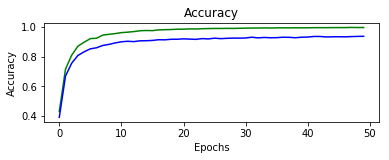

In [18]:
plt.figure()
accuracy = plt.subplot(2,1,1)
accuracy.set_title('Accuracy')
accuracy.plot(train_accuracies, 'g', label='Train')
accuracy.plot(validation_accuracies, 'b', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [19]:
import tensorflow as tf
import matplotlib.pyplot as plt

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    print("Test Accuracy = {:.3f}".format(evaluate(X_test_normed, y_test)))

INFO:tensorflow:Restoring parameters from ./model
Test Accuracy = 0.958


## Step 3: Test a Model on New Images

### Load and Output the Images

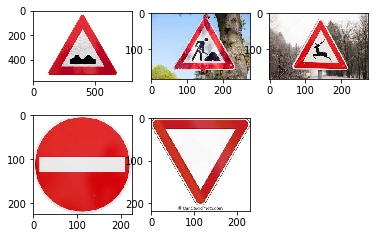

In [20]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline

image1=mpimg.imread('test_images/22_bumpy_road.jpg')
plt.subplot(2,3,1)
plt.imshow(image1)

image2=mpimg.imread('test_images/25_road_work.jpeg')
plt.subplot(2,3,2)
plt.imshow(image2)

image3=mpimg.imread('test_images/31_wild_animal_crossing.jpeg')
plt.subplot(2,3,3)
plt.imshow(image3)

image4=mpimg.imread('test_images/17_no_entry.jpeg')
plt.subplot(2,3,4)
plt.imshow(image4)

image5=mpimg.imread('test_images/13_yield.jpeg')
plt.subplot(2,3,5)
plt.imshow(image5)


truth_table=[22,25,31,17,13]

image1 = cv2.resize(image1, (32, 32))
image2= cv2.resize(image2 ,(32, 32))
image3= cv2.resize(image3,(32, 32))
image4=cv2.resize(image4,(32, 32))
image5=cv2.resize(image5,(32, 32))

### Predict the Sign Type for Each Image

In [21]:
test_figures = np.array([image1,image2,image3,image4,image5])
print("shape of test images:", test_figures.shape)
test_images = preprocess_imgs(test_figures)
print("preprocessing complete...")

shape of test images: (5, 32, 32, 3)
preprocessing complete...


In [22]:
prediction = tf.nn.softmax(logits)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    predictions = sess.run(prediction, feed_dict={x: test_images, keep_prob : dropout})
    for i in range(5):
        predict_label = np.argmax(predictions[i])
        print('Image', i, 'prediction:',  predict_label, ', the true label is', truth_table[i],'.')
    


INFO:tensorflow:Restoring parameters from ./model
Image 0 prediction: 22 , the true label is 22 .
Image 1 prediction: 25 , the true label is 25 .
Image 2 prediction: 31 , the true label is 31 .
Image 3 prediction: 17 , the true label is 17 .
Image 4 prediction: 13 , the true label is 13 .


### Analyze Performance

In [23]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    print("Test Accuracy = {:.3f}".format(evaluate(test_images, truth_table)))
    accuracy = evaluate(test_images, truth_table)
    percentage = accuracy * 100
    print("Prediction Accuracy for 5 images is {:.3f} %".format(percentage))

INFO:tensorflow:Restoring parameters from ./model
Test Accuracy = 1.000
Prediction Accuracy for 5 images is 100.000 %


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [37]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    predicts = sess.run(tf.nn.top_k(predictions, k=5, sorted=True))
    
for i in range(len(predicts[0])):
    print('Image', i, 'probabilities:', predicts[0][i], 'predicted classes:', predicts[1][i])


INFO:tensorflow:Restoring parameters from ./model
Image 0 probabilities: [  9.99759018e-01   2.31045269e-04   7.59536624e-06   1.24485859e-06
   1.02670526e-06] predicted classes: [22 26 39 29 33]
Image 1 probabilities: [  9.75023985e-01   2.21333727e-02   1.36412412e-03   8.32468388e-04
   3.59818601e-04] predicted classes: [25 20 35 13 36]
Image 2 probabilities: [  9.44168329e-01   5.57984710e-02   2.59735170e-05   3.49604375e-06
   3.45103581e-06] predicted classes: [31 21 29 23 19]
Image 3 probabilities: [  9.99914527e-01   4.61458621e-05   3.05246467e-05   5.84514191e-06
   1.54600752e-06] predicted classes: [17 33 13 12 10]
Image 4 probabilities: [  1.00000000e+00   2.32474799e-32   7.62282262e-38   1.88809862e-38
   0.00000000e+00] predicted classes: [13 15  9 39  0]


### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")